# AGN: Structure Functions

## Imports

In [30]:
from typing import Dict, List

import numpy as np
import pandas as pd

#from tape.analysis.base import AnalysisFunction
from tape.analysis.structure_function import SF_METHODS
from tape.analysis.structure_function.sf_light_curve import StructureFunctionLightCurve


__all__ = ["StructureFunction2", "calc_sf2"]


class StructureFunction2(AnalysisFunction):
    """Calculate structure function squared"""

    def cols(self, ens: "Ensemble") -> List[str]:
        return [
            ens._time_col,
            ens._flux_col,
            ens._err_col,
            ens._band_col,
            ens._id_col,
        ]

    def meta(self, ens: "Ensemble") -> Dict[str, type]:
        return {"lc_id": int, "band": str, "dt": float, "sf2": float, "1_sigma": float}

    def on(self, ens: "Ensemble") -> List[str]:
        return [ens._id_col]

    def __call__(
        self, time, flux, err=None, band=None, lc_id=None, *, sf_method="basic", argument_container=None
    ) -> pd.DataFrame:
        """Calculate structure function squared using one of a variety of structure
        function calculation methods defined by the input argument `sf_method`, or
        in the argument container object.


        Parameters
        ----------
        time : `numpy.ndarray` (N,) or `None`
            Array of times when measurements were taken. If all array values are
            `None` or if a scalar `None` is provided, then equidistant time between
            measurements is assumed.
        flux : `numpy.ndarray` (N,)
            Array of flux/magnitude measurements.
        err : `numpy.ndarray` (N,), `float`, or `None`, optional
            Array of associated flux/magnitude errors. If a scalar value is provided
            we assume that error for all measurements. If `None` is provided, we
            assume all errors are 0. By default None
        band : `numpy.ndarray` (N,), optional
            Array of associated band labels, by default None
        lc_id : `numpy.ndarray` (N,), optional
            Array of lightcurve ids per data point. By default None
        sf_method : str, optional
            The structure function calculation method to be used, by default "basic".
        argument_container : StructureFunctionArgumentContainer, optional
            Container object for additional configuration options, by default None.

        Returns
        -------
        sf2 : `pandas.DataFrame`
            Structure function squared for each of input bands.

        Notes
        ----------
        In case that no value for `band_to_calc` is passed, the function is
        executed on all available bands in `band`.
        """

        argument_container = _create_arg_container_if_needed(sf_method, argument_container)

        band = _validate_band(band, flux, argument_container)

        lc_id = _validate_lightcurve_id(lc_id, flux, argument_container)

        sf_method = _validate_sf_method(sf_method, argument_container)

        _validate_argument_container(argument_container)

        unq_band = np.unique(band)
        unq_ids = np.unique(lc_id)

        band_to_calc = argument_container.band_to_calc
        if band_to_calc is None:
            band_to_calc = unq_band
        if isinstance(band_to_calc, str):
            band_to_calc = [band_to_calc]

        assert hasattr(band_to_calc, "__iter__") is True

        ids = []
        dts = []
        bands = []
        sf2s = []
        sf2_err = []
        sf2_lower_error = []
        sf2_upper_error = []
        for b in band_to_calc:
            if b in unq_band:
                band_mask = band == b

                # Mask on band
                times = _extract_time(time=time, band_mask=band_mask, argument_container=argument_container)

                errors = _extract_error(err=err, band_mask=band_mask)

                fluxes = np.array(flux)[band_mask]
                lc_ids = np.array(lc_id)[band_mask]

                # Create stacks of critical quantities, indexed by id
                id_masks = [lc_ids == lc for lc in unq_ids]

                lightcurves = []
                for mask in id_masks:
                    try:
                        sf_lc = StructureFunctionLightCurve(
                            times=times[mask], fluxes=fluxes[mask], errors=errors[mask]
                        )
                        lightcurves.append(sf_lc)
                    except ValueError:
                        # Exception raised by StructureFunctionLightCurve when there are too few data point.
                        print("Attempted to create a Lightcurve with too few data points.")

                if len(lightcurves):
                    sf_calculator = SF_METHODS[sf_method](lightcurves, argument_container)

                    # `aggregated_dts` and `aggregated_sfs` will have the shape:
                    # [calc_rep(0:arg_container.calc_repetitions)][lc_id(0:num_lightcurves)][bin(0:num_dt_bins)]
                    aggregated_dts: List[np.ndarray] = []
                    aggregated_sfs: List[np.ndarray] = []
                    rng = np.random.default_rng(argument_container.random_seed)
                    for _ in range(argument_container.calculation_repetitions):
                        if argument_container.estimate_err:
                            sf_calculator._bootstrap(random_generator=rng)

                        tmp_dts, tmp_sfs = sf_calculator.calculate()
                        aggregated_dts.append(tmp_dts)
                        aggregated_sfs.append(tmp_sfs)

                    # find the median value for each (lightcurve, dt_bin) coordinate
                    res_dts = np.nanmedian(aggregated_dts, axis=0)
                    res_sfs = np.nanmedian(aggregated_sfs, axis=0)

                    if _no_results_found(aggregated_sfs):
                        res_err = np.zeros_like(res_sfs)
                        lower_error = np.zeros_like(res_err)
                        upper_error = np.zeros_like(res_err)
                    else:
                        # Subtract the upper and lower quantiles and remove the outer
                        # axis that has length 1. The resulting shape will be the same
                        # as `res_dts`` and `res_sfs`.
                        lower_quantile, upper_quantile = np.nanquantile(
                            aggregated_sfs,
                            (
                                argument_container.lower_error_quantile,
                                argument_container.upper_error_quantile,
                            ),
                            axis=0,
                        )

                        res_err = (upper_quantile - lower_quantile) / 2
                        lower_error = res_sfs - lower_quantile
                        upper_error = upper_quantile - res_sfs

                    res_ids = [[str(unq_ids[i])] * len(arr) for i, arr in enumerate(res_dts)]
                    res_bands = [[b] * len(arr) for arr in res_dts]

                    ids.append(np.hstack(res_ids))
                    bands.append(np.hstack(res_bands))
                    dts.append(np.hstack(res_dts))
                    sf2s.append(np.hstack(res_sfs))
                    sf2_err.append(np.hstack(res_err))
                    if argument_container.report_upper_lower_error_separately:
                        sf2_lower_error.append(np.hstack(lower_error))
                        sf2_upper_error.append(np.hstack(upper_error))

        id_stack = []
        band_stack = []
        dts_stack = []
        sf2_stack = []
        sigma_stack = []
        sf2_lower_stack = []
        sf2_upper_stack = []

        if len(ids):
            id_stack = np.hstack(ids)
            if argument_container.combine:
                id_stack = ["combined"] * len(id_stack)

            band_stack = np.hstack(bands)
            dts_stack = np.hstack(dts)
            sf2_stack = np.hstack(sf2s)
            sigma_stack = np.hstack(sf2_err)

            if argument_container.report_upper_lower_error_separately:
                sf2_lower_stack = np.hstack(sf2_lower_error)
                sf2_upper_stack = np.hstack(sf2_upper_error)

        data_frame_dict = {
            "lc_id": id_stack,
            "band": band_stack,
            "dt": dts_stack,
            "sf2": sf2_stack,
            "1_sigma": sigma_stack,
        }

        if argument_container.report_upper_lower_error_separately:
            data_frame_dict["lower_error"] = sf2_lower_stack
            data_frame_dict["upper_error"] = sf2_upper_stack

        sf2_df = pd.DataFrame(data_frame_dict)
        return sf2_df


calc_sf2 = StructureFunction2()
calc_sf2.__doc__ = StructureFunction2.__call__.__doc__


def _create_arg_container_if_needed(sf_method, argument_container):
    """If no argument container was provided, we'll create a default container
    with the default values using the value of `sf_method` to determine the correct
    type.

    Parameters
    ----------
    sf_method : str
        The structure function calculation method to be used.
    argument_container : StructureFunctionArgumentContainer
        Container object for additional configuration options.

    Returns
    -------
    StructureFunctionArgumentContainer
        Container object for additional configuration options.
    """

    if argument_container is None:
        argument_container_type = SF_METHODS[sf_method].expected_argument_container()
        argument_container = argument_container_type()
        argument_container.sf_method = sf_method

    return argument_container


def _validate_band(band, flux, argument_container):
    """The argument `band` can be set as an input argument or inside the
    `argument_container`. If `band` is provided in the function call with
    non-default values, we'll use those. Otherwise, we'll look inside
    `argument_container` and use the values found there. If we still can't find
    non-`None` values, we'll create a minimal fallback array of 1's with length
    equal to the input `flux` array.

    Parameters
    ----------
    band : `numpy.ndarray` (N,)
        Array of associated band labels.
    flux : `numpy.ndarray` (N,)
        Array of flux/magnitude measurements.
    argument_container : StructureFunctionArgumentContainer
        Container object for additional configuration options.

    Returns
    -------
    `numpy.ndarray` (N,)
        The band information to be used for structure function calculations.

    Raises
    ------
    ValueError
        If the provided band and flux arrays have different lengths, raise an
        exception.
    """

    if band is None:
        band = argument_container.band

    # if band is still `None`, create a fake array of bands. We'll use numpy int8
    # values to use as little memory as possible.
    if band is None:
        band = np.zeros(len(flux), dtype=np.int8)

    if len(band) != len(flux):
        raise ValueError(
            "Value of `band` should be `None` or array with the same length as the `flux` array."
        )

    return band


def _validate_lightcurve_id(lc_id, flux, argument_container):
    """The argument `lc_id` can be set as an input argument or inside the
    `argument_container`. If `lc_id` is provided in the function call with
    non-default values, we'll use those. Otherwise, we'll look inside
    `argument_container` and use the values found there. If we still can't find
    non-`None` values, we'll create a minimal fallback array of 1's with length
    equal to the input `flux` array.

    Parameters
    ----------
    lc_id : `numpy.ndarray` (N,), optional
        Array of lightcurve ids per data point.
    flux : `numpy.ndarray` (N,)
        Array of flux/magnitude measurements.
    argument_container : StructureFunctionArgumentContainer
        Container object for additional configuration options.

    Returns
    -------
    `numpy.ndarray` (N,)
        The lightcurve id information to be used for structure function
        calculations.

    Raises
    ------
    ValueError
        If the provided lc_id and flux arrays have different lengths, raise an
        exception.
    """

    if lc_id is None:
        lc_id = argument_container.lc_id

    # if the light curve value is still `None`, create an array of all 0's.
    # Using numpy.int8 values to save memory.
    if lc_id is None:
        lc_id = np.zeros(len(flux), dtype=np.int8)

    if len(lc_id) != len(flux):
        raise ValueError(
            "Value of `lc_id` should be `None` or array with the same length as the `flux` array."
        )

    return lc_id


def _validate_sf_method(sf_method, argument_container):
    """The argument `sf_method` can be set as an input argument or inside the
    `argument_container`. If `sf_method` is provided in the function call with
    a non-default value, we'll use that. If the default value for `sf_method`
    ("basic") has been provided, we'll check `argument_container` to see if the
    user provided a different `sf_method` value there.

    Parameters
    ----------
    sf_method : str, optional
        The structure function calculation method to be used, by default "basic".
    argument_container : StructureFunctionArgumentContainer
        Container object for additional configuration options.

    Returns
    -------
    `str`
        The band information to be used for structure function calculations.
    """

    if sf_method == "basic":
        sf_method = argument_container.sf_method

    if sf_method not in SF_METHODS:
        raise ValueError("Unknown structure function calculator method: " + str(sf_method))

    return sf_method


def _validate_argument_container(argument_container):
    """Raise an exception if this type of argument container does not match the
    type of argument container required by the structure function calculation
    method
    """

    if type(argument_container) is not SF_METHODS[argument_container.sf_method].expected_argument_container():
        raise TypeError("Argument container does not match Structure Function calculator method")


def _extract_time(time, band_mask, argument_container):
    """This will process the input time values, apply a band mask and return a
    numpy array of timestamps.

    Parameters
    ----------
    time : `numpy.ndarray` (N,) or `None`
        Array of times when measurements were taken. If all array values are
        `None` or if a scalar `None` is provided, then equidistant time between
        measurements is assumed.
    band_mask : `numpy mask` (N,)
        Array of associated band labels, by default None
    argument_container : StructureFunctionArgumentContainer, optional
        Container object for additional configuration options, by default None.
    """

    times = None

    # if the user passed in a scalar `None` value, or if explicitly ignoring
    # timestamps using the argument_container flag, create a numpy array
    # with a single `None` element. Otherwise assume the user passed an
    # array of timestamps to be masked with `band_mask`.
    # Note: some or all timestamps could be `None`.
    if time is None or argument_container.ignore_timestamps:
        times = np.array(None)
    else:
        times = np.array(time)[band_mask]

    # if all elements in `times` are `None`, we assume equidistant times
    # between measurements. To do so, we'll create an array of integers
    # from 0 to N-1 where N is the number of flux values for this band.
    if np.all(np.equal(times, None)):
        times = np.arange(sum(band_mask), dtype=int)

    return times


def _extract_error(err, band_mask):
    """Process the input err value(s), apply a band_mask, and return a numpy
    array of error values.

    Parameters
    ----------
    err : `numpy.ndarray` (N,), `float`, or `None`
        Array of associated flux/magnitude errors. If a scalar value is provided
        we assume that error for all measurements. If `None` is provided, we
        assume all errors are 0. By default None
    band_mask : `numpy mask` (N,)
        Array of associated band labels, by default None
    """

    errors = None
    # assume all errors are 0 if `None` is provided
    if err is None:
        errors = np.zeros(sum(band_mask))

    # assume the same error for all measurements if a scalar value is
    # provided
    elif np.isscalar(err):
        errors = np.ones(sum(band_mask)) * err

    # otherwise assume one error value per measurement
    else:
        errors = np.array(err)[band_mask]

    return errors


def _no_results_found(aggregated_sfs: List[np.ndarray]) -> bool:
    """This helper function determines if there are results from calculating
    the Structure Function for a given input. An example instances where there
    might not be results would be calculating the SF for a Lightcurve object
    that contains only 1 observation.

    Parameters
    ----------
    aggregated_sfs : List[np.ndarray]
        The output from the Structure Function calculation. This is a 3 dimensional
        array with dimensions [calculation_repetitions][lightcurve_id][sf_result]
        where calculation_repetition has range (0:arg_container.calc_repetitions)
        lightcurve_id has range (0:num_lightcurves)
        and sf_result has range (0:num_dt_bins)

    Returns
    -------
    bool
        True if no results were found.
    """

    no_results_found = False

    # `shape[2]==0` implies that there wasn't enough data to perform the SF calculation
    # For instance, only 1 observation.
    if np.shape(aggregated_sfs)[2] == 0:
        no_results_found = True

    return no_results_found

NameError: name 'AnalysisFunction' is not defined

In [15]:
# From TDAstro:

import numpy.typing as npt
def mag2flux(mag: npt.ArrayLike) -> npt.ArrayLike:
    """Convert AB magnitude to bandflux in nJy

    Parameters
    ----------
    mag : ndarray of float
        The magnitude to convert to bandflux.

    Returns
    -------
    bandflux : ndarray of float
        The bandflux corresponding to the input magnitude.
    """
    # AB definition is zp=8.9 for 1 Jy
    MAG_AB_ZP_NJY = 8.9 + 2.5 * 9
    return np.power(10.0, -0.4 * (mag - MAG_AB_ZP_NJY))

## Run

### Lightcurves

In [16]:
import numpy as np

In [17]:
# Checkpoint: start here to avoid dask

import pandas as pd

ndf = pd.read_pickle("/astro/users/olynn/sdss_x_ztf_partition_0.pkl")

In [18]:
def bin_redshift(val):
    return val.astype(int)
def bin_mass(val):
    return (val*0.5).astype(int)

ndf = ndf.assign(redshift_bin=lambda x: bin_redshift(x['REDSHIFT_sdss']))
ndf = ndf.assign(mass_bin=lambda x: bin_mass(x['LOGBH_sdss']))

In [19]:
import matplotlib.pyplot as plt

def plot_lightcurve(row, title=None):
    """Plot light curve."""
    bands = {
        1: "g",
        2: "r",
        3: "i"
    }
    colors = {
        1: "green",
        2: "red",
        3: "goldenrod"
    }

    band=bands[row["filterid_ztf"]]
    color=colors[row["filterid_ztf"]]

    plt.scatter(row["hmjd_ztf"], row["mag_ztf"], label=band, color=color, marker="x", s=10)
    plt.errorbar(row["hmjd_ztf"], row["mag_ztf"], row["magerr_ztf"], color=color, ls="")

    plt.legend()
    plt.title(title)
    plt.xlabel("HMJD")
    plt.ylabel("mag")
    plt.gca().invert_yaxis()

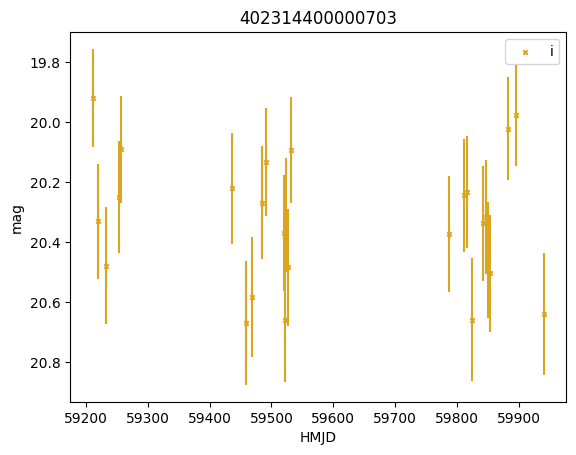

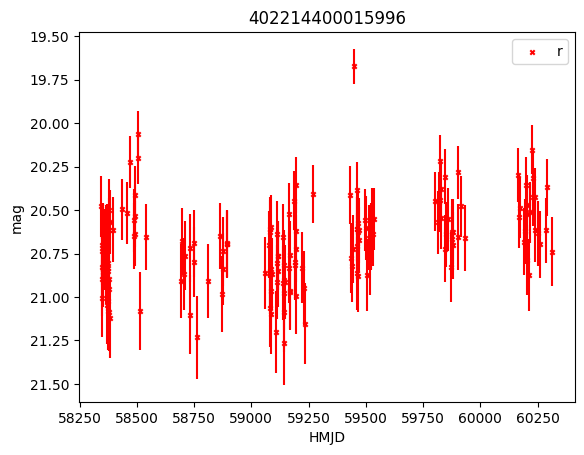

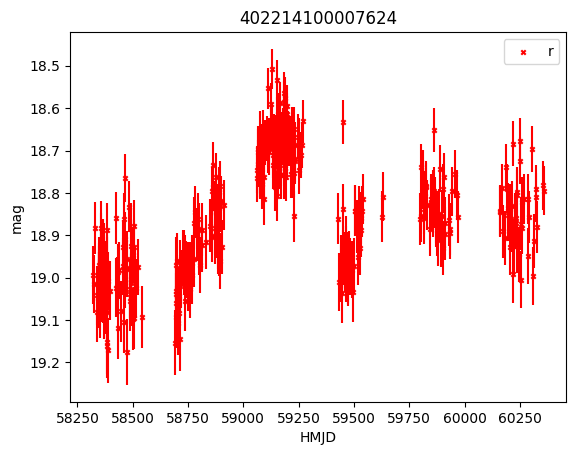

In [20]:
for i in range(3):
    row = ndf.iloc[i]
    object_id = ndf["objectid_ztf"].iloc[i]
    plt.figure()
    plot_lightcurve(row, title=object_id)

In [21]:
subset = ndf #.head(40)

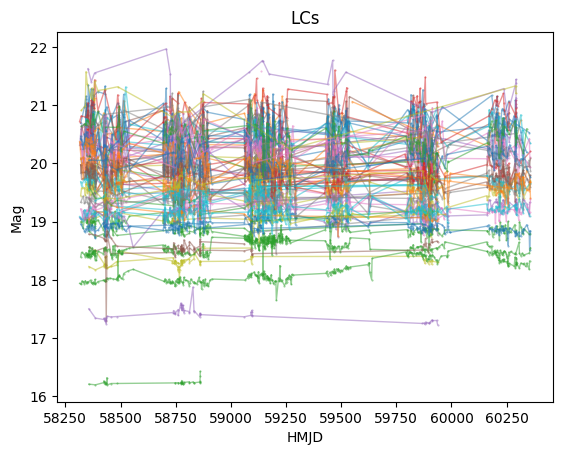

In [22]:
plt.figure()

for row in subset.itertuples():
    plt.plot(
        row[11],
        row[12],
        marker=".",
        linewidth=1,
        markersize=1,
        alpha=0.5
    )
    
plt.title("LCs")
plt.xlabel("HMJD")
plt.ylabel("Mag")
plt.show()

### Lomb Scargle

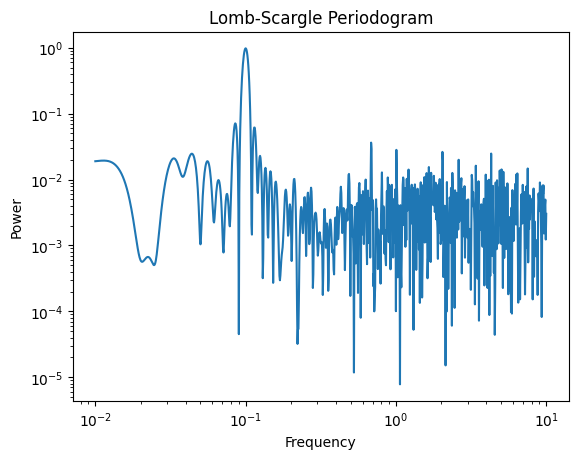

In [23]:
from astropy.timeseries import LombScargle

# Simulated uneven light curve
time = np.sort(np.random.uniform(0, 100, 500))  # 500 random time points
flux = np.sin(2 * np.pi * 0.1 * time) + 0.1 * np.random.randn(len(time))

# Define frequency grid
freqs = np.logspace(-2, 1, 1000)  # Log-spaced frequencies

# Compute Lomb-Scargle periodogram
ls = LombScargle(time, flux)
power = ls.power(freqs)

# Plot
plt.loglog(freqs, power)
plt.xlabel("Frequency")
plt.ylabel("Power")
plt.title("Lomb-Scargle Periodogram")
plt.show()

### SFs

In [24]:
subset

,RA_sdss,DEC_sdss,REDSHIFT_sdss,SDSS_NAME_sdss,LOGBH_sdss,objectid_ztf,objra_ztf,objdec_ztf,filterid_ztf,nepochs_ztf,hmjd_ztf,mag_ztf,magerr_ztf,_dist_arcsec,redshift_bin,mass_bin
_healpix_29,,,,,,,,,,,,,,,,
1748843545125,45.075508,0.152306,2.2308,030018.12+000908.3,9.273159,402314400000703,45.075535,0.152292,3,26,[59211.19299 59220.18693 59232.24832 59253.137...,[19.919155 20.330544 20.478958 20.249365 20.09...,[0.16309905 0.19148526 0.19479676 0.18755566 0...,0.10548,2,4
2976627715402,44.884758,0.164801,0.8064,025932.34+000953.2,8.307456,402214400015996,44.884762,0.164826,2,170,[58345.47684 58346.45576 58347.4427 58348.459...,[20.479105 21.008183 20.898762 20.825438 20.69...,[0.1734622 0.21954441 0.2100594 0.20370328 0...,0.092813,0,4
5459300610667,45.18858,0.282409,1.7422,030045.25+001656.6,9.3182,402214100007624,45.188557,0.282438,2,397,[58319.46343 58323.48325 58330.41979 58336.462...,[18.99347 19.013866 18.882828 19.041561 19.08...,[0.06750444 0.06855152 0.06210198 0.06999939 0...,0.134617,1,4
5858887011909,45.339138,0.290646,0.4101,030121.39+001726.3,7.203714,1447207200009528,45.339123,0.290644,2,58,[58356.39091 58386.38343 58423.37972 58424.296...,[19.812162 19.676159 19.867046 19.709583 19.71...,[0.12427196 0.11277227 0.12912114 0.11552699 0...,0.050533,0,3
7934686108383,45.189484,0.35918,1.4969,030045.47+002133.0,9.479626,402314100005023,45.189465,0.359199,3,66,[59184.33481 59187.27468 59200.28726 59203.257...,[19.072502 19.226034 19.1189 19.187363 19.26...,[0.10053448 0.11244124 0.10403369 0.1093551 0...,0.090226,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183364305466072,44.046345,1.20971,1.8652,025611.12+011234.9,9.389333,1447212400004328,44.046337,1.209713,2,26,[58423.37976 58425.30813 58429.32808 58432.318...,[20.811016 20.516762 20.660496 20.837013 20.35...,[0.21611822 0.19033718 0.20293033 0.21839595 0...,0.030953,1,4
183446950535900,44.04546,1.223442,0.9871,025610.91+011324.3,8.021559,1447112400002514,44.045422,1.223423,1,27,[58384.36184 58430.31485 58726.50292 58734.481...,[20.599236 20.843351 20.969254 21.203972 20.99...,[0.1637435 0.18248117 0.19214511 0.21016145 0...,0.154632,0,4
186480513263349,43.820339,1.192884,2.8391,025516.88+011134.3,9.302475,1447112300002877,43.820316,1.192892,1,55,[58384.36186 58427.33335 58430.31485 58436.247...,[19.531242 19.343212 19.497196 19.407978 19.38...,[0.08546226 0.07456639 0.08339607 0.078177 0...,0.099785,2,4


In [25]:
def apply_sf(sf_method="macleod_2012"):
    # "macleod_2012"
    results = {}
    for i in range(len(subset)):
        times = np.array(subset["hmjd_ztf"])[i]
        mags = np.array(subset["mag_ztf"])[i]
        errors_mag = np.array(subset["magerr_ztf"])[i]
        fluxes = mag2flux(mags)
        errors = mag2flux(errors_mag)
        redshift_bin = np.array(subset["redshift_bin"])[i]

        sf = calc_sf2(times, fluxes, errors, sf_method=sf_method)
        results.setdefault(redshift_bin, []).append(sf)
    return results

In [26]:
def plot_sfs(results, z_bin):
    plt.figure()
    for res in results[z_bin]:
        plt.plot(
                res["dt"],
                res["sf2"],
                marker=".",
                linewidth=1,
                markersize=2,
                alpha=0.25
            )
    plt.yscale("log")
    plt.xscale("log")
    plt.title(f"Structure Function^2 (z bin {z_bin})")
    plt.xlabel("Time [HMJD]")
    plt.ylabel("SF^2 [nJy^2]")
    plt.show()

In [27]:
# sfs = ['macleod_2012'] #, 'schmidt_2010'] #'basic', 'bauer_2009a', 'bauer_2009b']

# for sf in sfs:
#     res = apply_sf(sf)
#     for z_bin in res.keys():
#         plot_sfs(res, z_bin)

In [28]:
sf = "macleod_2012"
res = apply_sf(sf)

NameError: name 'calc_sf2' is not defined

In [ ]:
res[0][0]

In [ ]:
for z_bin in res.keys():
    plot_sfs(res, z_bin)